In [1]:
from pyspark.sql import SparkSession
import pyspark.sql.functions as F
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import statsmodels.formula.api as smf
import statsmodels.api as sm
import warnings
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.preprocessing import StandardScaler
import datetime as dt


warnings.filterwarnings('ignore')

pd.options.mode.chained_assignment = None

# Create a spark session (which will run spark jobs)
spark = (
    SparkSession.builder.appName("MAST30034 Project 1")
    .config("spark.sql.repl.eagerEval.enabled", True) 
    .config("spark.sql.parquet.cacheMetadata", "true")
    .config("spark.driver.memory", "4g")
    .config("spark.executor.memory", "8g")
    .getOrCreate()
)

22/08/20 12:00:33 WARN Utils: Your hostname, kelman_HP_ENVY resolves to a loopback address: 127.0.1.1; using 172.20.201.141 instead (on interface eth0)
22/08/20 12:00:33 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


22/08/20 12:00:35 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [2]:
yellow_19_20_sdf_agg = spark.read.parquet('../data/curated/yellow_19-20_agg/', header=True)
yellow_21_22_sdf_agg = spark.read.parquet('../data/curated/yellow_21-22_agg/', header=True)
fhvhv_19_20_sdf_agg = spark.read.parquet('../data/curated/fhvhv_19-20_agg/', header=True)
fhvhv_21_22_sdf_agg = spark.read.parquet('../data/curated/fhvhv_21-22_agg/', header=True)

yellow_21_22_sdf_agg_covid = spark.read.parquet('../data/curated/yellow_21-22_agg_covid/', header=True)
fhvhv_21_22_sdf_agg_covid = spark.read.parquet('../data/curated/fhvhv_21-22_agg_covid/', header=True)


In [3]:
yellow_21_22_df_agg_covid = yellow_21_22_sdf_agg_covid.toPandas()
fhvhv_21_22_df_agg_covid = fhvhv_21_22_sdf_agg_covid.toPandas()
yellow_19_20_df_agg = yellow_19_20_sdf_agg.toPandas()
yellow_21_22_df_agg = yellow_21_22_sdf_agg.toPandas()
fhvhv_19_20_df_agg = fhvhv_19_20_sdf_agg.toPandas()
fhvhv_21_22_df_agg = fhvhv_21_22_sdf_agg.toPandas()

In [4]:
def plot(model):
    fig, axes = plt.subplots(nrows=2, ncols=2)

    # residual vs fitted plot
    sns.scatterplot(model.fittedvalues, model.resid, ax=axes[0, 0])
    axes[0, 0].axhline(y=0, color='red', linestyle='dashed')
    axes[0, 0].set_title('Residuals vs Fitted')

    # qq plot
    sm.qqplot(model.resid, ax=axes[0, 1], line='r')
    axes[0, 1].set_title('Normal Q-Q')

    # scale-location plot
    sns.scatterplot(model.fittedvalues, model.resid_pearson, ax=axes[1, 0])
    axes[1, 0].set_title('Scale-Location')

    # standardised residuals vs leverage
    sns.scatterplot(model.get_influence().hat_matrix_diag, model.resid_pearson, ax=axes[1, 1])
    axes[1, 1].axhline(y=0, color='red', linestyle='dashed')
    axes[1, 1].set_title('Standardised Residuals vs Leverage')

    plt.tight_layout()
    plt.show()

In [99]:
yellow_19_20_df_agg

,date,trip_count,trip_distance_avg,total_amount_avg,trip_time_avg,tip_percent_avg
0,2019-12-28,101583,3.324445,20.852260,13.923137,15.234600
1,2019-12-10,168013,3.038804,21.413708,16.758039,15.256495
2,2020-01-17,181473,2.834729,19.481808,13.773036,15.182674
3,2019-12-18,190673,2.783217,19.858501,15.022278,15.233354
4,2019-12-04,182665,2.983673,20.772942,15.848523,15.242619
...,...,...,...,...,...,...
86,2020-02-13,180311,2.747478,19.258520,13.977246,15.189187
87,2020-02-28,191761,2.856777,19.788515,14.414576,15.119679
88,2020-02-02,150241,2.671556,17.960207,12.026805,15.031743
89,2020-02-03,135706,3.111035,19.558036,13.045385,15.028196


<h2><u>Model 1</u></h2>

In [15]:
def model1_train_predict(df_agg_covid):
    columns = ['trip_count', 'CASE_COUNT', 'HOSPITALIZED_COUNT']
    model_df = df_agg_covid.loc[:, columns]

    train_data, test_data = train_test_split(model_df, test_size=0.2, random_state=42)

    baseline = smf.ols(formula='trip_count ~ 1', data=train_data).fit()
    model = smf.ols("trip_count ~ CASE_COUNT + HOSPITALIZED_COUNT", data=train_data).fit()

    # baseline train data
    baseline_pred_train = baseline.predict(train_data)
    print('Baseline RMSE on train data: ', mean_squared_error(train_data['trip_count'], baseline_pred_train, squared=False)) 
    print('Baseline R2 on train data: ', r2_score(train_data['trip_count'], baseline_pred_train))

    # baseline test data
    baseline_pred_test = baseline.predict(test_data)
    print('Baseline RMSE on test data: ', mean_squared_error(test_data['trip_count'], baseline_pred_test, squared=False)) 
    print('Baseline R2 on test data: ', r2_score(test_data['trip_count'], baseline_pred_test))

    print('')

    # model train data
    model_pred = model.predict(train_data)
    print('Model RMSE on train data: ', mean_squared_error(train_data['trip_count'], model_pred, squared=False)) 
    print('Model R2 on train data: ', r2_score(train_data['trip_count'], model_pred))

    # model test data
    model_pred = model.predict(test_data)
    print('Model RMSE on test data: ', mean_squared_error(test_data['trip_count'], model_pred, squared=False)) 
    print('Model R2 on test data: ', r2_score(test_data['trip_count'], model_pred))

    print('')

    return model


In [37]:
def find_min_max(df, feature, name):
    print(f'Min {name}: ', df[feature].min())
    print(f'Max {name}: ', df[feature].max())

**Yellow Taxi**

Baseline RMSE on train data:  16378.276332250223
Baseline R2 on train data:  0.0
Baseline RMSE on test data:  21596.55206977868
Baseline R2 on test data:  -0.009864115702498122

Model RMSE on train data:  11546.75786531838
Model R2 on train data:  0.5029687110383708
Model RMSE on test data:  15657.199730910012
Model R2 on test data:  0.46921055001211587

Min daily trip count:  26790
Max daily trip count:  100420


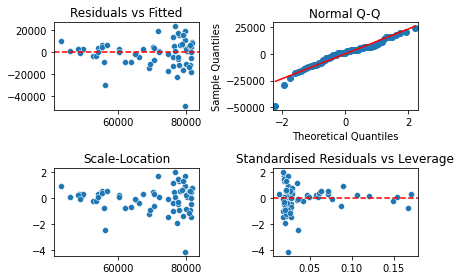

In [38]:
yellow_model1 = model1_train_predict(yellow_21_22_df_agg_covid)
find_min_max(yellow_21_22_df_agg_covid, 'trip_count', 'daily trip count')
plot(yellow_model1)

**HVFHV**

Baseline RMSE on train data:  95954.6975138223
Baseline R2 on train data:  2.220446049250313e-16
Baseline RMSE on test data:  102583.44631075107
Baseline R2 on test data:  -0.017413412037613485

Model RMSE on train data:  78430.1178463183
Model R2 on train data:  0.3319126421686326
Model RMSE on test data:  75356.04356898804
Model R2 on test data:  0.4509915041757163

Min daily trip count:  211026
Max daily trip count:  726324


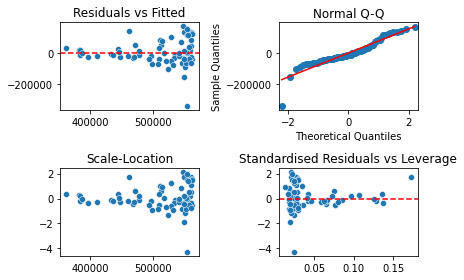

In [23]:
hvfhv_model1 = model1_train_predict(fhvhv_21_22_df_agg_covid)
find_min_max(fhvhv_21_22_df_agg_covid, 'daily trip count')
plot(hvfhv_model1)

<h2><u>Model 2</u></h2>

In [94]:
def model2(df_19_20, df_21_22):  
    train_data = df_19_20

    test_data = df_21_22

    baseline = smf.ols(formula='tip_percent_avg ~ 1', data=train_data).fit()
    columns = "+".join(train_data.columns.difference(['tip_percent_avg', 'date']))
    model = smf.ols("tip_percent_avg ~ " + columns, data=train_data).fit()

    # baseline train data
    baseline_pred_train = baseline.predict(train_data)
    print('Baseline RMSE on train data: ', mean_squared_error(train_data['tip_percent_avg'], baseline_pred_train, squared=False)) 
    print('Baseline R2 on train data: ', r2_score(train_data['tip_percent_avg'], baseline_pred_train))

    # baseline test data
    baseline_pred_test = baseline.predict(test_data)
    print('Baseline RMSE on test data: ', mean_squared_error(test_data['tip_percent_avg'], baseline_pred_test, squared=False)) 
    print('Baseline R2 on test data: ', r2_score(test_data['tip_percent_avg'], baseline_pred_test))
    
    print('')

    # model train data
    model_pred = model.predict(train_data)
    print('Model RMSE on train data: ', mean_squared_error(train_data['tip_percent_avg'], model_pred, squared=False)) 
    print('Model R2 on train data: ', r2_score(train_data['tip_percent_avg'], model_pred))

    # model test data
    model_pred = model.predict(test_data)
    print('Model RMSE on test data: ', mean_squared_error(test_data['tip_percent_avg'], model_pred, squared=False)) 
    print('Model R2 on test data: ', r2_score(test_data['tip_percent_avg'], model_pred))

    print('')

    return model

**Yellow Taxi**

Baseline RMSE on train data:  0.10000017518776073
Baseline R2 on train data:  0.0
Baseline RMSE on test data:  0.3433810728124108
Baseline R2 on test data:  -4.700367561597555

Model RMSE on train data:  0.08068844801641147
Model R2 on train data:  0.34893971682814695
Model RMSE on test data:  0.21486332760885432
Model R2 on test data:  -1.2319000840979668

Min average trip percent:  15.242085473477747
Max average trip percent:  16.117934504252013


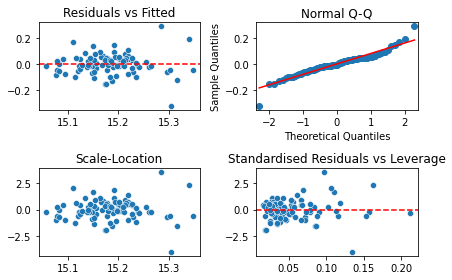

In [95]:
yellow_model2 = model2(yellow_19_20_df_agg, yellow_21_22_df_agg)
find_min_max(yellow_21_22_df_agg, 'tip_percent_avg', 'average trip percent')
plot(yellow_model2)

**HVFHV**

Baseline RMSE on train data:  0.10534840344161359
Baseline R2 on train data:  0.0
Baseline RMSE on test data:  0.746321559804374
Baseline R2 on test data:  -20.53815634381976

Model RMSE on train data:  0.08956166981279678
Model R2 on train data:  0.2772494219541307
Model RMSE on test data:  0.8843262606684675
Model R2 on test data:  -29.239986532864872

Min average trip percent:  2.712114582094739
Max average trip percent:  3.3719618084272724


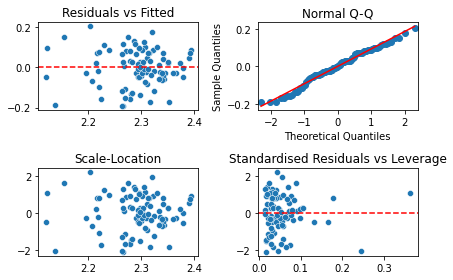

In [98]:
fhvhv_model2 = model2(fhvhv_19_20_df_agg, fhvhv_21_22_df_agg)
find_min_max(fhvhv_21_22_df_agg, 'tip_percent_avg', 'average trip percent')
plot(fhvhv_model2)